# Exercise 2

## Part a

First I read in the dataset and extract all title names. Then I split titles into lists of words which could be used in model fitting later on. I also insert indices into the dataframe by using `monotonically_increasing_id()` from the `pyspark.sql.functions` library.

In [1]:
import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.ml.feature import *
from pyspark.sql.types import *
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import *

In [2]:
sc=pyspark.SparkContext()

In [3]:
spark = SparkSession(sc)

In [4]:
titles = []
with open('publications.txt') as f:
    for line in f.readlines():
        if re.match('^#\*(.*)', line):
            line = line.strip('#*').strip('.\n')
            title = line.split(' ')
            titles.append(title)

In [5]:
spark = SparkSession\
        .builder\
        .appName("CountVectorizerExample")\
        .getOrCreate()
spark.conf.set("spark.executor.memory", "2g")

In [6]:
schema = ArrayType(StringType(), True)

In [7]:
df = spark.createDataFrame(titles, schema)

In [8]:
df_index = df.select("*").withColumn("id", monotonically_increasing_id())

In [9]:
df_train = df_index.select("id", "value")

After transforming the words into vectors, we are able to fit models. I set vocabulary size equals 1000 to find the top 1000 words in all titles. Finally, run PCA on those word count vectors with number of principal components set to 50.

In [10]:
cv = CountVectorizer(inputCol="value", outputCol="features", vocabSize=1000)

In [11]:
model = cv.fit(df_train)

In [12]:
result = model.transform(df_train)

In [13]:
result.printSchema()

root
 |-- id: long (nullable = false)
 |-- value: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)



In [14]:
pca50 = PCA(k=50,inputCol="features", outputCol="pcaFeatures")
pca100 = PCA(k=100,inputCol="features", outputCol="pcaFeatures")

modelpca = pca50.fit(result)
modelpca100 = pca100.fit(result)

result1 = modelpca.transform(result)

result1.show(truncate=False)


+---+------------------------------------------------------------------------------------------------+-------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Part b

In this part, we want to use the result of PCA. We plot the explained variance for each principal conponent. Call `modelpca.pc` to find the principal components (which are also eigenvectors) and `modelpca.explainedVariance` to calculate how many components are needed to explain 50% of the total variance. 

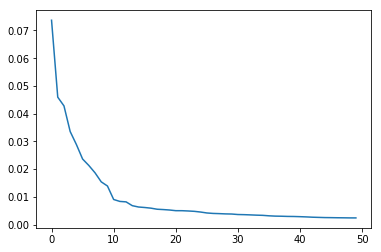

In [15]:
%matplotlib inline
temp=list(modelpca.explainedVariance)
plt.plot(temp)

Here I also plot the cumulative variance of the principal components resulted by PCA. As it shows, the total explained variance for those 50 principal components add up to around 0.48 so we may say those principal components could not perfectly represent the whole dataset.

In [16]:
cum=[]
cum_sum=0
for e in temp:
    cum_sum+=e
    cum.append(cum_sum)

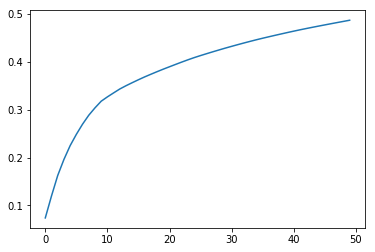

In [17]:
plt.plot(cum)

In [18]:
total_variance_50 = np.sum(modelpca.explainedVariance)
total_variance_50

0.4872000593327849

In [19]:
total_variacne_100 = np.sum(modelpca100.explainedVariance)

In [20]:
sum=0
count=0
for num in modelpca.explainedVariance:
    if sum > total_variance_50 / 2:
        break
    sum+=num
    count+=1
count

6

In [21]:
sum100=0
count100=0
for num in modelpca100.explainedVariance:
    if sum100 > 0.5:
        break
    sum100+=num
    count100+=1
count100

56

The result here indicates that if we are only interested in the explained variance of the 50 principal components, we only need 6 principal components to cover half of the total variance. But if we see this from the view of 1000 frequent words, we may need 56 principal components. 

## Part c

First I cast the principal components vectors to a `ndarray` and then use `pandas.DataFrame` to calculate the sum of squares. We can see that the sum of squares of all principal components add up to 1 which indicates that the vectors are perfectly normalized. 

In [22]:
pcs=modelpca.pc.toArray()

In [23]:
squares=pd.DataFrame(pcs**2)

In [24]:
squares.loc['sum of squares'] = squares.apply(lambda x: x.sum())

In [25]:
squares

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,7.713030e-01,5.466990e-02,3.366907e-03,2.233763e-02,1.110122e-01,7.172152e-03,1.612938e-02,1.977117e-05,9.510373e-05,4.632948e-03,...,2.715343e-05,4.128359e-05,3.135716e-07,3.506792e-05,3.962402e-05,2.660260e-05,2.802213e-07,2.150219e-06,4.067092e-05,1.004581e-05
1,4.755195e-02,6.822671e-01,1.113306e-01,4.756070e-02,1.888760e-02,4.164299e-02,5.088963e-03,5.248963e-03,9.051433e-05,2.145358e-02,...,2.895365e-05,2.995486e-05,1.398201e-06,2.407098e-06,3.447286e-04,9.334070e-05,1.184268e-05,2.864123e-06,1.779442e-06,1.162972e-04
2,2.146778e-02,1.002422e-01,8.721419e-01,4.749638e-04,1.686325e-04,8.845578e-04,4.173291e-04,6.404690e-04,1.616251e-05,1.774556e-04,...,1.448312e-05,3.951794e-07,3.675490e-07,6.538207e-06,2.464872e-05,2.581170e-05,1.524436e-05,7.753006e-06,4.925464e-06,4.798047e-08
3,4.062728e-03,6.508431e-02,4.942667e-03,7.774476e-01,1.032745e-01,1.040460e-02,2.716256e-03,9.678372e-03,3.204050e-03,7.958790e-03,...,4.509981e-06,3.128262e-05,1.041737e-06,5.410634e-06,2.535866e-05,1.486652e-04,1.367222e-07,8.478298e-05,1.970289e-05,1.190933e-07
4,1.343453e-01,2.058347e-02,1.408217e-04,1.289468e-01,6.389472e-01,2.928929e-02,5.568098e-03,1.114414e-02,4.875125e-04,1.734107e-02,...,7.325058e-06,3.385701e-05,5.766554e-05,1.836867e-05,4.369476e-05,4.810784e-06,2.938565e-05,4.854318e-07,5.874020e-05,3.725433e-05
5,3.514258e-03,6.303934e-02,2.873048e-03,2.342931e-03,6.592647e-03,7.877282e-01,4.437953e-02,1.351616e-02,5.000016e-03,3.794925e-02,...,8.265175e-05,3.185320e-06,1.735839e-04,1.269695e-07,1.476789e-05,3.604963e-06,1.768819e-04,1.166889e-04,5.136791e-04,5.415351e-06
6,6.247667e-03,1.324351e-03,1.471843e-04,1.156729e-03,5.368805e-02,6.123746e-02,8.259859e-01,1.542630e-03,4.632846e-03,2.700708e-02,...,7.743390e-06,9.824717e-06,4.062941e-04,5.035860e-05,4.011895e-05,1.215215e-07,6.495148e-06,1.960416e-08,8.939644e-05,1.646731e-06
7,2.911719e-03,7.277892e-04,6.186928e-06,6.424212e-03,3.721369e-02,1.245586e-02,3.204100e-02,7.283929e-01,1.248884e-02,6.852845e-02,...,5.732476e-05,3.369043e-04,4.162292e-04,8.720152e-05,8.733980e-05,3.287400e-05,8.999296e-07,1.026030e-05,2.299015e-07,2.206812e-04
8,1.101017e-04,9.771430e-04,3.002226e-04,3.843368e-03,3.403015e-05,3.469736e-03,1.024277e-02,5.033654e-02,8.467515e-01,6.996162e-02,...,3.528393e-05,3.379936e-06,2.622333e-05,6.050952e-06,4.090854e-05,4.913921e-05,6.478918e-05,4.413844e-06,5.982736e-05,1.304525e-04
9,1.599098e-04,2.513021e-03,5.396886e-04,5.106282e-05,1.653438e-02,1.792320e-02,3.477707e-02,9.594054e-02,1.036439e-01,6.622244e-01,...,3.222438e-07,1.935947e-06,7.044918e-05,2.773745e-04,6.155184e-06,7.306961e-06,4.884439e-04,5.599717e-05,2.394004e-04,1.134043e-03


Then we'd like to see the words for those components that are larger than 0.2 of the norm. 

In [26]:
import numpy as np
vocab=[]
for i in range(50):
    temp=[]
    for j in range(1000):
        if np.abs(squares[i][j]) > 0.2:
            temp.append(model.vocabulary[j])
    vocab.append(temp)

In [27]:
vocab

[['of'],
 ['for'],
 ['and'],
 ['in'],
 ['the'],
 ['A'],
 ['a'],
 ['on'],
 ['with'],
 ['to'],
 ['The'],
 ['Using'],
 ['An'],
 ['Using', 'Systems'],
 ['Systems', 'Networks'],
 ['using', 'Networks'],
 ['System'],
 ['by'],
 ['Data'],
 ['-'],
 ['Analysis'],
 ['System', 'an'],
 ['-'],
 ['On', 'from'],
 ['On', 'from'],
 ['Model'],
 ['Design', 'systems'],
 ['Design'],
 ['systems', 'networks'],
 ['Information'],
 ['Information', 'Algorithm'],
 ['based'],
 ['Network'],
 ['Network'],
 ['Approach', 'Learning'],
 ['analysis'],
 ['system', 'Web'],
 ['system'],
 ['Software', 'Web'],
 ['Performance', 'Software'],
 ['Control'],
 ['Distributed'],
 ['model'],
 ['model', 'data'],
 [],
 ['de'],
 ['Efficient', 'de'],
 ['Efficient'],
 ['New', 'Image'],
 ['approach', 'algorithm']]

## Part d

From the result in item b and c, it seems this dataset is not quite fit PCA method because there are many words like 'of', 'the' in the titles. But the interesting thing here is that those noise-like words are actually more frequent than others and becomes the dimensions that we want to keep. Another thing is about the explained variance. Technically, there is no obvious plato for the graph of explained variance which means we still need a lot of principal components to explain most of the variance. So PCA may not quite run well on this problem. 

In [28]:
sample_d = result1.sample(fraction=0.1)

In [29]:
sample_array_d=np.array(sample_d.select('pcaFeatures').collect())

In [30]:
sample_d_x=[]
sample_d_y=[]
for i in range(len(sample_array_d)):
    sample_d_x.append(sample_array_d[i][0][0])
    sample_d_y.append(sample_array_d[i][0][1])

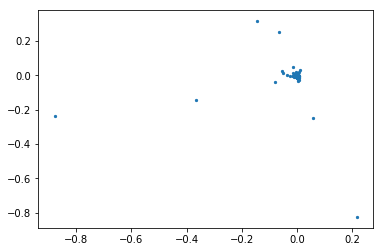

In [31]:
plt.scatter(x=pcs[:, 0], y=pcs[:, 1], s=5)

Here I plot the principal components first because I just want to see how it changes when we change the preprocessing and modeling method. So in the following part, I make scatter plot of sample points as well as principal components. 

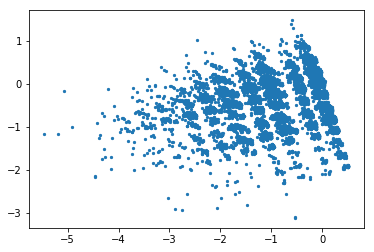

In [32]:
plt.scatter(x=sample_d_x, y=sample_d_y, s=5)

There is no obvious structure from my point of view, just a bunch of point cloud and a few outliers in the plot. Comparing this to the result in item b and c, we may say that those outliers have more variance which could be the words like 'of' or 'the'. And the majority of other words just join together to form a cloud. 

## Part e

In [33]:
stopwords=[]
with open('stopwords_english.txt') as f:
    for line in f.readlines():
        line=line.strip('\n')
        stopwords.append(line)

In [34]:
remover=StopWordsRemover(inputCol='value',outputCol='features',stopWords=stopwords)
removed=remover.transform(df_train)

In [35]:
cve = CountVectorizer(inputCol="features", outputCol="features_removed", vocabSize=1000)
removed_cv = cve.fit(removed)

In [36]:
res_e = removed_cv.transform(removed)

In [37]:
parte=PCA(k=50, inputCol="features_removed", outputCol="res")
modele = parte.fit(res_e)

In [38]:
resulte = modele.transform(res_e)
resulte.show(truncate=False)

+---+------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------+-----------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

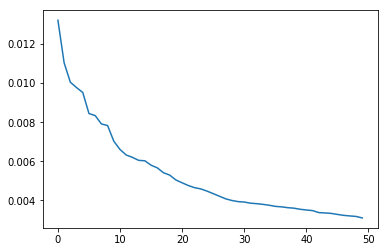

In [39]:
var_e=list(modele.explainedVariance)
plt.plot(var_e)

In [40]:
cum_e=[]
cum_sum_e=0
for e in var_e:
    cum_sum_e+=e
    cum_e.append(cum_sum_e)

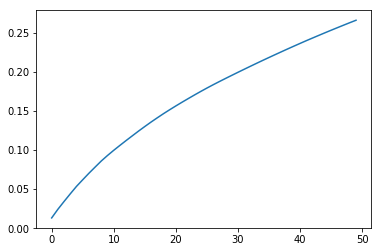

In [41]:
plt.plot(cum_e)

In [42]:
total_variance_e = np.sum(modele.explainedVariance)
total_variance_e

0.26594514187677426

In [43]:
sum_e=0
count_e=0
for num in modele.explainedVariance:
    if sum_e > total_variance_e / 2:
        break
    sum_e+=num
    count_e+=1
count_e

17

The total explained variance for top 50 principal components drops and it also takes more principal components to explained half of the variance. 

In [44]:
pcs_e=modele.pc.toArray()

In [45]:
squares_e=pd.DataFrame(pcs_e**2)

In [46]:
squares_e.loc['sum of squares'] = squares_e.apply(lambda x: x.sum())

Then we'd like to see the words for those components that are larger than 0.2 of the norm. 

In [47]:
vocab_e=[]
for i in range(50):
    temp=[]
    for j in range(1000):
        if np.abs(squares_e[i][j]) > 0.2:
            temp.append(removed_cv.vocabulary[j])
    vocab_e.append(temp)

In [48]:
vocab_e

[['Using'],
 ['Using'],
 ['Systems', 'Networks'],
 ['using'],
 ['System', 'Networks'],
 ['System', 'Based'],
 ['Data'],
 ['Analysis'],
 ['-'],
 ['based'],
 ['Model'],
 ['Design'],
 ['systems'],
 ['networks'],
 ['Information', 'Algorithm', 'networks'],
 ['Approach', 'Information'],
 ['Algorithm'],
 ['Network'],
 ['Learning'],
 ['analysis'],
 ['system'],
 ['system', 'Web'],
 ['Web'],
 ['Performance', 'Software'],
 ['Control'],
 ['Distributed'],
 ['model'],
 ['model', 'data'],
 [],
 ['de'],
 ['approach', 'Efficient'],
 ['approach', 'Efficient'],
 ['New', 'Management'],
 ['algorithm', 'Image'],
 ['algorithm'],
 ['Mobile'],
 ['Dynamic', 'Study'],
 ['Mobile', 'Study'],
 ['Parallel'],
 ['Modeling'],
 ['control'],
 ['Application'],
 ['Method'],
 [],
 ['Wireless'],
 ['Detection'],
 ['Applications'],
 ['Adaptive'],
 ['Adaptive', 'Algorithms'],
 ['design']]

Here I pick samples from all the titles where I set the fraction of samples to 0.1 which hopefully would give me about 7000 random titles as the sample.  

In [49]:
sample = resulte.sample(fraction=0.1)

In [50]:
sample_array_e=np.array(sample.select('res').collect())

In [51]:
sample_e_x=[]
sample_e_y=[]
for i in range(len(sample_array_e)):
    sample_e_x.append(sample_array_e[i][0][0])
    sample_e_y.append(sample_array_e[i][0][1])

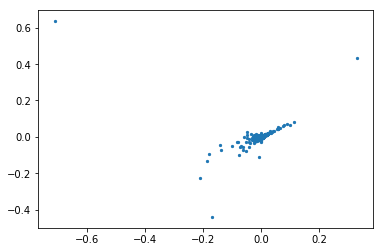

In [52]:
plt.scatter(x=pcs_e[:, 0], y=pcs_e[:, 1], s=5)

Here we can see that the principa compoents distributed more loosely in the horizontal direction. This difference in direction shows the axis of pricipal components and is a measure when the data is projected into that axis. 

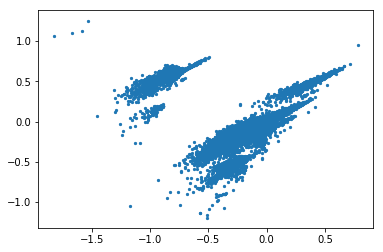

In [53]:
plt.scatter(x=sample_e_x, y=sample_e_y, s=5)

Comparing this plot to the scatter plot in item d, some vague structure seems to appear. Based on the result of rerunning b-c, I think after filtering out the stopwords, there is less difference between the exlpained variance for each pricipal components since most of the words don't appear too many times. This change could be seen from the plot in part b. The data point also shows the same direction of axis as the plot of corresponding principal components. 

## Part f

In [54]:
#idf feature

idf = IDF(inputCol="pcaFeatures", outputCol="res")
idfModel = idf.fit(result1)
rescaledData = idfModel.transform(result1)

rescaledData.select("res").show()

+--------------------+
|                 res|
+--------------------+
|[-1.4299796170243...|
|[0.01116324098617...|
|[0.25426316330911...|
|[-1.4244119848313...|
|[-0.1123468486105...|
|[-0.0699417705005...|
|[-0.0711378351249...|
|[-0.0715404886298...|
|[-1.0819315258689...|
|[-1.1796873380423...|
|[0.0,0.0,0.0,0.0,...|
|[-0.2244204403172...|
|[-0.0843765973677...|
|[-0.0542214625225...|
|[-4.4617286753351...|
|[-0.1850774047908...|
|[0.0,0.0,0.0,0.0,...|
|[-0.0714056289737...|
|[-0.0691447006246...|
|[0.00162670887404...|
+--------------------+
only showing top 20 rows



In [55]:
partf_pca=PCA(k=50, inputCol="res", outputCol="tfidf_pca")

In [56]:
modelf=partf_pca.fit(rescaledData)
resultf=modelf.transform(rescaledData)

In [57]:
var_f=list(modelf.explainedVariance)

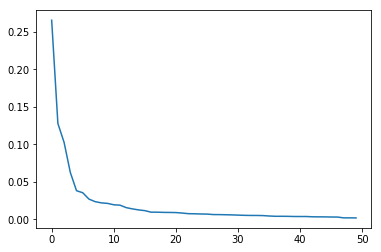

In [58]:
plt.plot(var_f)

In [59]:
cum_f=[]
cum_sum_f=0
for e in var_f:
    cum_sum_f+=e
    cum_f.append(cum_sum_f)

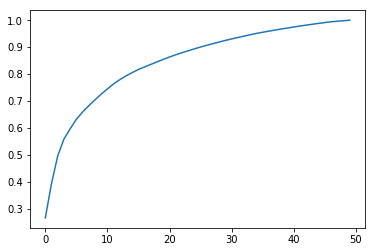

In [60]:
plt.plot(cum_f)

In [61]:
total_variance_f = np.sum(modelf.explainedVariance)
total_variance_f

0.9999999999999997

In [62]:
sum_f=0
count_f=0
for num in modelf.explainedVariance:
    if sum_f > total_variance_f / 2:
        break
    sum_f+=num
    count_f+=1
count_f

4

Here the result is much better, the total variance for the top 50 principal components just add up to one. And we only need 4 principal components to explain half of all variance.

In [63]:
pcs_f=modelf.pc.toArray()

In [64]:
squares_f=pd.DataFrame(pcs_f**2)

In [65]:
squares_f.loc['sum of squares'] = squares_f.apply(lambda x: x.sum())

In [66]:
squares_f

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.000000e+00,4.002927e-29,2.228775e-28,6.732244e-30,2.399848e-30,5.170555e-31,1.661490e-31,2.351302e-30,5.740808e-30,3.080603e-30,...,8.815863e-34,2.453323e-32,8.240031e-32,6.247754e-33,3.835849e-32,1.043585e-32,3.688126e-34,4.421741e-32,1.141652e-34,5.751755e-35
1,4.002927e-29,1.000000e+00,2.133080e-27,3.009266e-30,5.117003e-30,1.496478e-29,3.167782e-30,4.612133e-30,5.697671e-30,4.190101e-32,...,1.473224e-32,2.240234e-32,9.244255e-31,2.343635e-32,7.229760e-34,6.272793e-33,4.640466e-34,1.464772e-33,2.941859e-33,8.930130e-36
2,2.228775e-28,2.143347e-27,1.000000e+00,3.971452e-28,1.146622e-29,7.173896e-30,7.583470e-31,3.254822e-30,7.858565e-30,1.925930e-32,...,2.178547e-33,2.444281e-32,4.049268e-32,3.351993e-33,1.677816e-31,8.850927e-32,7.664884e-33,1.913912e-32,5.855975e-33,6.519321e-34
3,1.615573e-30,1.509929e-31,4.892170e-29,7.099748e-30,1.972152e-29,1.346025e-28,1.964641e-30,2.959461e-29,6.295603e-28,8.491348e-29,...,2.104422e-32,1.156762e-32,2.418614e-31,1.670218e-32,5.486764e-31,1.880791e-35,7.253101e-32,3.009266e-32,1.673021e-32,6.941177e-34
4,1.405841e-31,2.359264e-31,1.083336e-30,6.039716e-31,1.171736e-30,2.502939e-30,3.254822e-32,3.205980e-29,1.874777e-29,2.959461e-29,...,3.591728e-32,3.910841e-32,2.836203e-31,3.161610e-32,2.591531e-30,8.954446e-34,3.846029e-33,2.717374e-31,3.193498e-32,2.190210e-34
5,2.399848e-30,6.174105e-30,1.239783e-29,7.119470e-29,1.000000e+00,1.518570e-27,1.644938e-29,3.159007e-29,5.207715e-31,1.301929e-29,...,1.024362e-31,2.023430e-32,1.203706e-33,1.432711e-32,5.007719e-32,6.134456e-31,6.046536e-32,4.261421e-32,2.791424e-32,4.518083e-32
6,5.170555e-31,1.463232e-29,6.734925e-30,4.962797e-29,1.492722e-27,1.000000e+00,2.122837e-29,9.984021e-31,8.172876e-30,3.938334e-30,...,2.303969e-32,1.925930e-32,4.814825e-33,3.478711e-33,3.644341e-31,1.156762e-32,3.009266e-36,2.890099e-32,4.935948e-33,1.076575e-32
7,1.661490e-31,3.018973e-30,7.657715e-31,2.555944e-29,1.972152e-29,1.597443e-29,1.000000e+00,8.697191e-29,5.762556e-29,4.776383e-29,...,3.965279e-31,9.321501e-32,2.750276e-30,3.910841e-32,1.733337e-31,2.043219e-30,3.530057e-33,1.591901e-31,1.090637e-31,1.226382e-33
8,1.051617e-30,7.835062e-31,3.060860e-31,8.097005e-31,8.389351e-31,3.081488e-31,5.435745e-30,6.520428e-30,7.285841e-30,8.389351e-31,...,2.359596e-30,2.309238e-30,1.456485e-29,1.156039e-31,2.359264e-31,6.534801e-31,2.034264e-33,1.925930e-34,8.540975e-31,1.899646e-33
9,6.732244e-30,2.700734e-30,4.154503e-28,1.000000e+00,7.493101e-29,4.814825e-29,2.496005e-29,2.773339e-30,5.697671e-30,3.667741e-30,...,7.827100e-33,1.738152e-32,6.478828e-31,3.774823e-32,5.512493e-31,1.474540e-32,2.687349e-32,1.676041e-31,5.484386e-34,6.059955e-33


Again, the principal components are well normalized. Then we'd like to see the words for those components that are larger than 0.2 of the norm. 

In [67]:
vocab_f=[]
for i in range(50):
    temp=[]
    for j in range(50):
        if np.abs(squares_f[i][j]) > 0.2:
            temp.append(model.vocabulary[j])
    vocab_f.append(temp)

In [68]:
vocab_f

[['of'],
 ['for'],
 ['and'],
 ['to'],
 ['A'],
 ['a'],
 ['on'],
 ['using'],
 ['-'],
 ['Systems'],
 ['On'],
 ['in'],
 ['the'],
 ['analysis'],
 ['Efficient'],
 ['an'],
 ['networks'],
 ['Analysis'],
 ['Design'],
 ['System'],
 ['Approach'],
 ['Based'],
 ['The'],
 ['An'],
 ['model'],
 ['Performance'],
 ['New'],
 ['with'],
 ['Networks'],
 ['systems'],
 ['algorithm'],
 ['system'],
 ['Algorithm'],
 ['Using'],
 ['Dynamic'],
 ['Control'],
 ['data'],
 ['based'],
 ['Distributed'],
 ['Management'],
 ['Network'],
 ['Software'],
 ['by'],
 ['Model'],
 ['from'],
 ['Data'],
 ['Learning'],
 ['approach'],
 ['Information'],
 ['Web']]

Here I pick samples from all the titles where I set the fraction of samples to 0.1 which hopefully would give me about 7000 random titles as the sample.  

In [69]:
sample_f = resultf.sample(fraction=0.1)

In [70]:
sample_array_f=np.array(sample_f.select('tfidf_pca').collect())

In [71]:
sample_f_x=[]
sample_f_y=[]
for i in range(len(sample_array_f)):
    sample_f_x.append(sample_array_f[i][0][0])
    sample_f_y.append(sample_array_f[i][0][1])

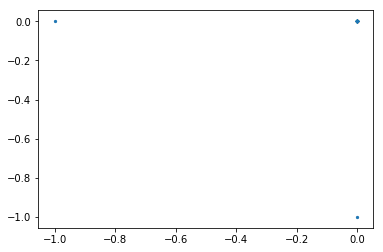

In [72]:
plt.scatter(x=pcs_f[:, 0], y=pcs_f[:, 1], s=5)

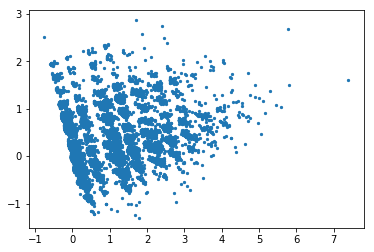

In [73]:
plt.scatter(x=sample_f_x, y=sample_f_y, s=5)

There seems to have some small group of points in the plot, based on the good result of explained variance part, I think we may say the top 2 components are able to cover a great portion of variance. 

## part i

In [74]:
nips=[]
vldb=[]
with open('publications.txt') as f:
    for line in f.readlines():
        if re.match('^#\*(.*)', line):
            temp=line.strip('.\n').strip('#*').split(' ')
        if line == '#cNIPS\n':
            nips.append(temp)
        if line == '#cVLDB\n':
            vldb.append(temp)

In [75]:
nips_df=spark.createDataFrame(nips, schema)
vldb_df=spark.createDataFrame(vldb, schema)
nips_df=nips_df.withColumn('venue', lit(0))
vldb_df=vldb_df.withColumn('venue', lit(1))

In [76]:
parti_df=nips_df.union(vldb_df)

In [77]:
parti_df.show()

+--------------------+-----+
|               value|venue|
+--------------------+-----+
|[CAM, Storage, of...|    0|
|[Grammatical, Inf...|    0|
|[Breaking, SVM, C...|    0|
|[Co-Training, and...|    0|
|[Hidden, Markov, ...|    0|
|[Large-Scale, Pre...|    0|
|[On, the, Distrib...|    0|
|[Genetic, Algorit...|    0|
|[Policy-Gradient,...|    0|
|[A, Recurrent, Ne...|    0|
|[An, Orientation,...|    0|
|[Connectivity, Ve...|    0|
|[Financial, Appli...|    0|
|[A, Method, for, ...|    0|
|[Probabilistic, I...|    0|
|[Q-Learning, with...|    0|
|[Support, Vector,...|    0|
|[Sampling, Techni...|    0|
|[Associative, Lea...|    0|
|[Nonparametric, M...|    0|
+--------------------+-----+
only showing top 20 rows



In [78]:
parti_cv = CountVectorizer(inputCol="value", outputCol="features", vocabSize=1000)

In [79]:
parti_cvmodel = parti_cv.fit(parti_df)

In [80]:
parti_cvresult = model.transform(parti_df)

In [81]:
parti_cvresult.show()

+--------------------+-----+--------------------+
|               value|venue|            features|
+--------------------+-----+--------------------+
|[CAM, Storage, of...|    0|(1000,[0,2,8,289,...|
|[Grammatical, Inf...|    0|(1000,[0,3,17,21,...|
|[Breaking, SVM, C...|    0|(1000,[8,166],[1....|
|[Co-Training, and...|    0|(1000,[2,76,141,9...|
|[Hidden, Markov, ...|    0|(1000,[1,64,222,3...|
|[Large-Scale, Pre...|    0|(1000,[0,235,820]...|
|[On, the, Distrib...|    0|(1000,[0,4,6,7,20...|
|[Genetic, Algorit...|    0|(1000,[2,61,120,1...|
|[Policy-Gradient,...|    0|(1000,[1,144,231]...|
|[A, Recurrent, Ne...|    0|(1000,[0,3,4,5,25...|
|[An, Orientation,...|    0|(1000,[1,3,11,33,...|
|[Connectivity, Ve...|    0|        (1000,[],[])|
|[Financial, Appli...|    0|(1000,[0,23,34,58...|
|[A, Method, for, ...|    0|(1000,[0,1,4,5,51...|
|[Probabilistic, I...|    0|(1000,[0,23,270,3...|
|[Q-Learning, with...|    0|    (1000,[8],[1.0])|
|[Support, Vector,...|    0|(1000,[8,22,91,97...|


In [82]:
parti_idf=IDF(inputCol="features", outputCol="tfidf_result")
parti_tfidf_model=parti_idf.fit(parti_cvresult)
parti_tfidf_result=parti_tfidf_model.transform(parti_cvresult)

In [83]:
parti_pca=PCA(k=50, inputCol="tfidf_result", outputCol="tfidf_pca")

In [84]:
parti_tfidf_pca_model=parti_pca.fit(parti_tfidf_result)

In [85]:
parti_tfidf_pca_result=parti_tfidf_pca_model.transform(parti_tfidf_result)

In [86]:
parti_cv_pca_model=pca50.fit(parti_cvresult)

In [87]:
parti_cv_pca_result=parti_cv_pca_model.transform(parti_cvresult)

In [88]:
var_cv_i=list(parti_cv_pca_model.explainedVariance)
var_tfidf_i=list(parti_tfidf_pca_model.explainedVariance)

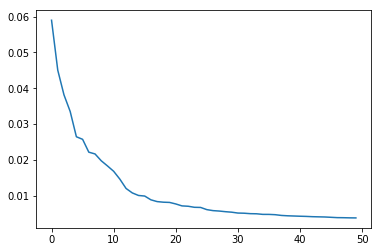

In [89]:
plt.plot(var_cv_i)

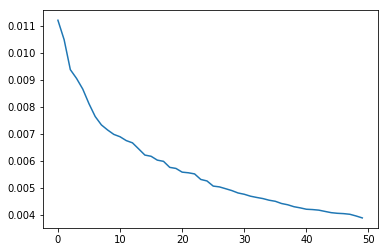

In [90]:
plt.plot(var_tfidf_i)

In [91]:
cum_cv_i=[]
cum_sum_cv_i=0
for e in var_cv_i:
    cum_sum_cv_i+=e
    cum_cv_i.append(cum_sum_cv_i)

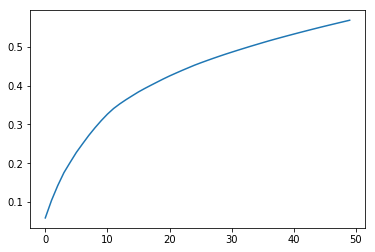

In [92]:
plt.plot(cum_cv_i)

In [93]:
cum_tfidf_i=[]
cum_sum_tfidf_i=0
for e in var_tfidf_i:
    cum_sum_tfidf_i+=e
    cum_tfidf_i.append(cum_sum_tfidf_i)

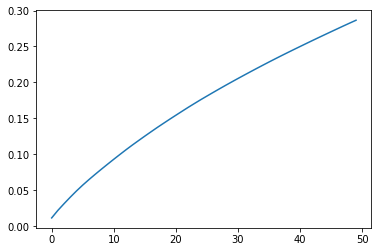

In [94]:
plt.plot(cum_tfidf_i)

In [95]:
total_variance_cv_i = np.sum(parti_cv_pca_model.explainedVariance)
total_variance_cv_i

0.5687133400956935

In [96]:
total_variance_tfidf_i = np.sum(parti_tfidf_pca_model.explainedVariance)
total_variance_tfidf_i

0.28657343928645124

In [97]:
sum_cv_i=0
count_cv_i=0
for num in parti_cv_pca_model.explainedVariance:
    if sum_cv_i > total_variance_cv_i / 2:
        break
    sum_cv_i+=num
    count_cv_i+=1
count_cv_i

9

In [98]:
sum_tfidf_i=0
count_tfidf_i=0
for num in parti_tfidf_pca_model.explainedVariance:
    if sum_tfidf_i > total_variance_tfidf_i / 2:
        break
    sum_tfidf_i+=num
    count_tfidf_i+=1
count_tfidf_i

20

The number of principal components that we need to explain half of the variance is 9 and 20. 

In [99]:
pcs_tfidf_i=parti_tfidf_pca_model.pc.toArray()
pcs_cv_i=parti_cv_pca_model.pc.toArray()

In [100]:
squares_cv_i=pd.DataFrame(pcs_cv_i**2)
squares_tfidf_i=pd.DataFrame(pcs_tfidf_i**2)

In [101]:
squares_cv_i.loc['sum of squares'] = squares_cv_i.apply(lambda x: x.sum())
squares_tfidf_i.loc['sum of squares'] = squares_tfidf_i.apply(lambda x: x.sum())

In [102]:
squares_cv_i

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,5.955805e-01,2.920496e-01,2.042688e-02,6.284133e-05,1.148873e-02,9.590896e-05,1.100843e-03,3.976780e-02,2.074569e-04,4.234255e-03,...,2.024307e-05,2.691081e-05,1.037045e-05,1.996879e-05,2.509535e-05,1.961506e-04,9.653173e-05,2.599411e-04,9.614824e-05,1.025328e-04
1,2.891542e-01,4.509793e-01,6.526692e-04,1.098618e-01,6.877189e-02,6.828646e-05,6.084549e-04,3.690528e-03,1.042692e-02,1.672778e-04,...,2.988297e-04,4.654063e-04,2.758714e-04,3.909576e-05,2.753858e-04,3.348931e-04,1.754224e-03,1.268590e-04,1.061459e-04,4.417291e-05
2,1.111524e-02,4.860662e-03,9.566707e-01,2.256388e-04,5.032796e-03,3.196527e-03,1.637103e-03,1.099541e-03,2.196115e-03,5.863924e-05,...,1.476238e-09,4.233347e-05,6.856037e-05,7.639221e-07,1.968787e-05,1.958955e-05,3.718172e-05,1.522160e-04,1.433318e-05,4.797468e-05
3,2.847737e-02,1.363581e-01,4.698240e-04,7.236881e-01,2.260123e-03,2.020519e-03,2.278516e-03,5.089945e-03,2.466764e-03,2.505174e-02,...,3.549681e-04,3.214044e-05,4.834083e-06,8.393917e-06,9.320144e-06,1.826264e-04,1.853453e-06,2.268232e-04,6.099372e-05,8.012926e-05
4,3.828620e-02,1.155101e-02,7.803188e-07,1.840912e-02,7.495488e-04,4.968971e-02,1.680990e-05,7.734803e-01,1.750925e-02,6.932483e-03,...,2.758409e-03,6.972389e-05,1.439154e-06,3.084527e-05,1.377529e-04,1.832378e-03,4.335295e-08,6.497991e-04,1.609376e-04,7.591903e-05
5,8.376737e-03,4.913022e-02,4.705361e-05,1.404085e-02,5.208861e-01,2.250654e-01,8.372799e-04,4.348025e-02,3.046713e-05,2.026124e-02,...,1.718011e-04,6.049625e-04,4.257620e-04,1.950650e-03,3.362790e-04,1.730922e-03,2.859198e-03,7.999006e-03,1.953189e-07,9.805105e-04
6,7.576718e-03,7.518322e-04,7.918561e-04,1.783608e-02,3.918871e-05,6.985607e-03,4.615914e-02,1.397981e-03,5.356890e-01,1.534172e-01,...,1.164165e-04,8.719391e-06,9.980122e-05,1.073650e-03,1.436963e-05,6.366846e-04,2.219789e-05,9.665377e-04,5.174348e-04,1.731199e-04
7,6.475104e-04,2.764291e-04,7.411321e-05,1.252161e-04,8.857901e-04,1.559466e-03,3.226880e-04,3.855435e-03,5.482464e-10,3.596926e-05,...,4.734300e-03,2.524513e-05,1.560167e-04,2.575808e-03,9.573955e-04,1.183900e-03,5.388318e-04,9.390356e-04,4.342575e-04,5.421589e-04
8,1.563379e-06,1.264858e-02,9.647073e-04,5.243376e-02,1.135101e-02,4.266056e-02,5.342067e-02,3.256694e-02,2.006332e-01,5.053400e-01,...,5.081030e-04,8.321636e-04,1.908935e-03,1.040690e-07,1.386917e-05,8.760513e-05,4.042684e-04,2.100058e-06,1.280403e-05,3.166022e-04
9,6.466430e-04,6.671131e-03,5.454631e-05,1.551243e-02,4.429355e-02,4.505098e-02,2.817838e-02,1.686058e-02,9.225252e-03,1.674061e-01,...,3.558560e-03,4.477031e-04,1.083043e-03,1.368125e-04,5.523797e-05,1.702012e-04,1.419292e-03,1.317742e-03,1.680142e-04,3.909493e-05


In [103]:
squares_tfidf_i

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,7.931356e-02,3.350878e-02,8.172914e-02,5.859947e-02,5.633017e-03,3.192882e-04,9.378114e-03,0.001565,4.712900e-02,5.761283e-03,...,5.376098e-03,2.343775e-03,1.100418e-03,6.350119e-04,5.443829e-05,4.144028e-04,1.443376e-02,6.189908e-06,3.194372e-03,3.264591e-03
1,6.250085e-03,2.495845e-02,1.977002e-02,1.231033e-04,4.343143e-02,1.950966e-02,2.986318e-05,0.016028,9.118556e-03,5.157598e-03,...,8.260904e-04,1.186490e-03,1.075832e-03,3.294429e-03,2.328061e-04,4.486939e-04,2.014630e-03,8.890101e-03,2.047023e-02,1.101359e-02
2,9.338028e-03,1.429318e-04,4.510138e-03,1.382335e-02,1.305121e-02,6.973021e-06,8.761807e-03,0.098339,2.202397e-02,1.184617e-01,...,1.348587e-03,3.374064e-04,3.306086e-04,6.611131e-04,2.120717e-03,2.118453e-04,1.567499e-03,1.109996e-03,5.492865e-03,2.259453e-04
3,3.302540e-02,7.877816e-03,5.196001e-03,9.951535e-03,3.730954e-02,9.288308e-03,6.261692e-02,0.093063,5.304980e-02,2.673620e-02,...,6.535468e-03,2.246113e-03,8.507978e-04,1.223732e-04,3.566820e-03,1.367805e-05,2.616204e-04,2.744893e-03,1.982974e-02,5.070311e-04
4,1.036002e-01,4.002936e-02,2.436906e-01,1.947050e-02,5.514101e-02,2.649130e-02,7.268349e-02,0.025758,5.100597e-02,5.056054e-02,...,1.555407e-03,4.482430e-04,3.165853e-06,1.920944e-03,7.095328e-04,1.626370e-04,1.776326e-03,1.349220e-02,2.170228e-03,1.117141e-03
5,1.153396e-02,6.006140e-02,3.016844e-03,9.774928e-02,1.884160e-01,8.360343e-02,1.276390e-02,0.001860,9.412525e-03,2.010230e-02,...,3.086064e-03,3.026493e-03,2.339308e-03,2.201475e-03,1.238706e-04,2.451263e-03,6.200263e-04,8.807742e-04,1.250720e-04,5.142780e-04
6,1.140679e-01,1.707981e-04,1.136087e-02,3.954019e-03,3.354062e-01,1.348474e-01,1.586749e-02,0.001229,1.053823e-03,8.228794e-04,...,7.179538e-04,1.113423e-05,2.880897e-05,1.937726e-03,1.188617e-07,2.435290e-03,2.436611e-05,1.543979e-02,1.784859e-03,1.316240e-06
7,1.303511e-02,2.937719e-04,1.935457e-04,7.675370e-03,3.490620e-03,8.581704e-03,1.688298e-02,0.035017,2.386439e-03,2.271075e-03,...,1.049900e-02,3.900444e-03,2.324233e-03,1.437945e-03,2.723113e-03,2.805807e-03,4.906665e-04,8.181154e-09,4.850072e-03,3.197051e-04
8,1.735176e-02,2.147355e-02,1.210813e-02,3.372764e-02,4.166289e-02,1.928695e-03,2.270168e-02,0.139349,1.442247e-01,8.181507e-02,...,7.387031e-04,3.138055e-03,1.052874e-05,5.351196e-03,3.334117e-03,2.481914e-04,3.001092e-05,2.065624e-03,4.775649e-03,4.387688e-03
9,6.585454e-03,1.338807e-03,6.980066e-02,3.350935e-01,7.639123e-03,9.456743e-02,1.799270e-07,0.031654,2.000951e-02,3.244015e-03,...,1.724546e-04,1.542636e-03,8.070764e-04,3.680741e-03,1.853104e-03,2.546667e-05,8.824009e-04,2.201882e-03,3.896481e-03,1.086360e-03


Again, the principal components are well normalized. Then we'd like to see the words for those components that are larger than 0.2 of the norm. 

In [104]:
vocab_cv_i=[]
for i in range(50):
    temp=[]
    for j in range(1000):
        if np.abs(squares_cv_i[i][j]) > 0.2:
            temp.append(parti_cvmodel.vocabulary[j])
    vocab_cv_i.append(temp)
    
vocab_tfidf_i=[]
for i in range(50):
    temp=[]
    for j in range(1000):
        if np.abs(squares_tfidf_i[i][j]) > 0.2:
            temp.append(parti_cvmodel.vocabulary[j])
    vocab_tfidf_i.append(temp)

In [105]:
vocab_cv_i

[['for', 'of'],
 ['for', 'of'],
 ['and'],
 ['in'],
 ['Learning'],
 ['Learning', 'by', 'Approach'],
 ['by', 'Approach'],
 ['A'],
 ['Data', 'with'],
 ['with'],
 ['Inference'],
 ['a'],
 ['Nonlinear'],
 ['Network'],
 ['Network', 'Nonlinear'],
 ['to'],
 ['Model', 'Modeling'],
 ['Model'],
 [],
 ['the', 'Modeling'],
 [],
 ['Neural', 'Randomized'],
 ['The'],
 ['Methods', 'State'],
 ['on'],
 ['Structure', 'Novel'],
 ['Clustering'],
 ['Structures'],
 ['An', 'System'],
 ['Clustering'],
 ['Value'],
 [],
 [],
 ['Linear'],
 [],
 [],
 [],
 [],
 ['Information'],
 [],
 [],
 [],
 [],
 [],
 ['Neighbor'],
 [],
 [],
 [],
 [],
 []]

In [106]:
vocab_tfidf_i

[[],
 [],
 ['A'],
 ['a'],
 ['Data'],
 [],
 ['by'],
 [],
 [],
 [],
 [],
 ['and'],
 ['Approach'],
 [],
 [],
 ['to'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [107]:
sample_array_cv_i=np.array(parti_cv_pca_result.select('pcaFeatures').collect())
sample_array_tfidf_i=np.array(parti_tfidf_pca_result.select('tfidf_pca').collect())

In [108]:
sample_cv_i_x=[]
sample_cv_i_y=[]
for i in range(len(sample_array_cv_i)):
    sample_cv_i_x.append(sample_array_cv_i[i][0][0])
    sample_cv_i_y.append(sample_array_cv_i[i][0][1])

sample_tfidf_i_x=[]
sample_tfidf_i_y=[]
for i in range(len(sample_array_tfidf_i)):
    sample_tfidf_i_x.append(sample_array_tfidf_i[i][0][0])
    sample_tfidf_i_y.append(sample_array_tfidf_i[i][0][1])

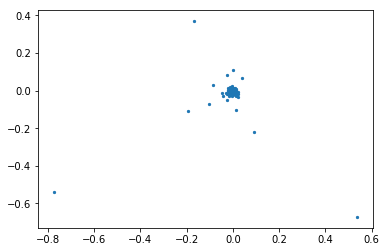

In [109]:
plt.scatter(x=pcs_cv_i[:, 0],y=pcs_cv_i[:, 1], s=5)

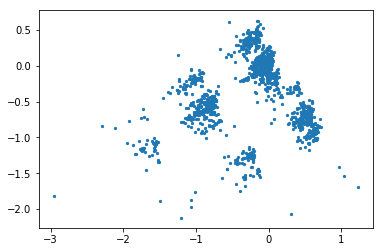

In [110]:
plt.scatter(x=sample_cv_i_x, y=sample_cv_i_y, s=5)

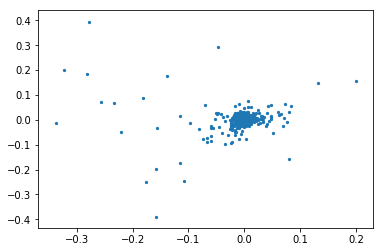

In [111]:
plt.scatter(x=pcs_tfidf_i[:, 0], y=pcs_tfidf_i[:, 1], s=5)

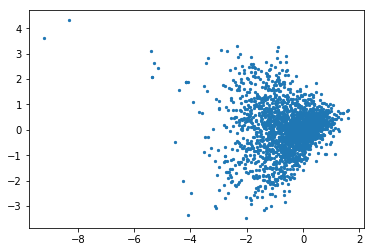

In [112]:
plt.scatter(x=sample_tfidf_i_x, y=sample_tfidf_i_y, s=5)

As we see in the explained variance part, there seems to have no obvious structure here because of the evenly distributed variance among all principal components. 

## Part j

In [113]:
resulti_cv=parti_cv_pca_model.transform(parti_cvresult)
resulti_tfidf=parti_tfidf_pca_model.transform(parti_tfidf_result)

In [114]:
cv_array_i=np.array(resulti_cv.select('pcaFeatures','venue').collect())
tfidf_array_i=np.array(resulti_tfidf.select('tfidf_pca','venue').collect())

In [115]:
#2450 is the length of merged list
cvx=[]
cvy=[]
for i in range(2450):
    cvx.append(cv_array_i[i][0][0])
    cvy.append(cv_array_i[i][0][1])

In [116]:
tfidfx=[]
tfidfy=[]
for i in range(2450):
    tfidfx.append(tfidf_array_i[i][0][0])
    tfidfy.append(tfidf_array_i[i][0][1])

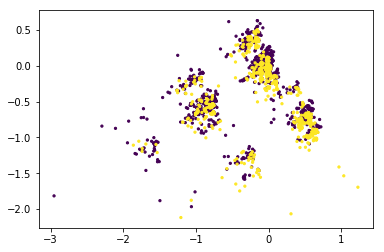

In [117]:
plt.scatter(x=cvx,y=cvy,c=cv_array_i[:, 1],s=5)

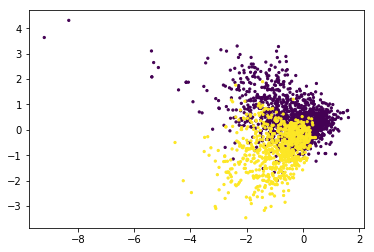

In [118]:
plt.scatter(x=tfidfx,y=tfidfy,c=tfidf_array_i[:, 1], s=5)

The difference between word count and TF-IDF is really obvious. As we can see from the two plot, there appears to have two groups of points which we could regard as titles from different venues. 